## Example Queries for Numerator

In this tutorial notebook, we utilize the Python API to query Kellogg's Numerator dataset hosted on Redivis. The API uses a web browser to authenticate Kellogg users via SSO, so no additional steps are required beyond installing the ```redivis``` Python module via pip. We also choose to view/manipulate the downloaded data using Pandas and Matplotlib, though there are many other options available as well (e.g., polars, seaborn, ggplot, dplyr, etc.)

Structured Query Language (SQL) is a nearly universal language for querying relational databases. Redivis uses Google's BigQuery as a backend for its cloud database design. These queries may need to be modified slightly to run on other databases as they use functions designed and optimized for BigQuery instead of AWS/Athena, for example.

In [2]:
import redivis
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
%matplotlib inline

## Example 1: Average daily price of a carton of eggs

In [17]:
with open("egg_prices.sql", "r") as f:
    egg_prices_sql = f.read()

display(Markdown(f"```sql\n{egg_prices_sql}\n```"))

```sql
WITH items AS (
  SELECT item_id, batch_date
  FROM `standard_nmr_feed_item_table`
  WHERE majorcat_id = 'isc_gro_dai_eggs'
  AND category_id = 'isc_gro_dai_egg_cage_free'
  AND item_description like '%12%'
), prices as (
  SELECT 
    trans.transaction_date, trans.item_unit_price
  FROM `standard_nmr_feed_fact_table` trans
  JOIN items
  ON items.item_id = trans.item_id
  AND items.batch_date = trans.batch_date
  WHERE (
    items.batch_date = '2024-05-13' AND
    EXTRACT(YEAR from DATE(trans.transaction_date)) < 2024
  ) OR
  (
    items.batch_date = '2024-10-21' AND
    EXTRACT(Year FROM DATE(trans.transaction_date)) >= 2024
  )
)
SELECT 
  transaction_date,
  AVG(item_unit_price) as avg_price,
  STDDEV(item_unit_price) as std_price,
  APPROX_QUANTILES(item_unit_price, 100)[OFFSET(24)] as lq_price,
  APPROX_QUANTILES(item_unit_price, 100)[OFFSET(49)] AS median_price,
  APPROX_QUANTILES(item_unit_price, 100)[OFFSET(74)] AS uq_price
FROM prices
GROUP BY transaction_date

```

#### Step 1: querying the fact table

The ```standard_nmr_feed_item_table```,  or simply, the item table, contains information on every individual item purchased in the Numerator dataset. The data are categorized using a hierarchical index.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Level</th>
      <th>Description</th>
      <th>ID</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Sector</td>
      <td>Grocery</td>
      <td>isc_grocery</td>
    </tr>
    <tr>
      <td>Department</td>
      <td>Dairy</td>
      <td>isc_gro_dairy</td>
    </tr>
    <tr>
      <td>Major Category</td>
      <td>Eggs</td>
      <td>isc_gro_dai_eggs</td>
    </tr>
    <tr>
      <td>Category</td>
      <td>Cage Free Eggs</td>
      <td>isc_gro_dai_egg_cage_free</td>
    </tr>
    <tr>
      <td>Sub-category</td>
      <td></td>
      <td></td>
    </tr>
  </tbody>
</table>

We expect there to be quite a bit of variance in the prices of eggs based on the product type. In this example, we chose to only select cage-free eggs, however, there are many other categories that fall under the major category of eggs (i.e., hard-boiled, free-range, egg substitute, etc.). Including the major category in the filter along with the category is redundant, but we include it in this example in case the user wishes to look at a different category.

It's also important we are comparing prices of products with the same quantity of eggs. Unfortunately, obtaining the carton-size is not as trivial as the step before. Because this is just an example, we'll make a rough attempt at selecting out cartons with a dozen eggs by doing a grep search on the number "12". Naturally, this might miss product descriptions using abbreviations like "DZ" for dozen instead of "12ct" or may include descriptions with product IDs instead of counts, but we can adjust for those incorrect values by aggregating our data in a smart manner below.

#### Step 2: querying the fact table

All of the transactions are located in the facts table. In this case, a singular transaction is called a "basket" that has one row for every unique item included in the transaction.

To get all the transactions related to eggs, we join the previous query with the fact table on the item ID. We also join on batch date to ensure that we retrieve the correct version of the dataset. If we want to include data from 2018-2024, we have to include data from two different batches: (1) batch_date='2024-05-13' for all data from 2018-01-01 through 2023-12-31 and (2)batch_date='2024-10-21' for 2024-01-01 through 2024-09-30.

#### Step 3: aggregating the data

Our final step is to get the average daily prices. We show this in a couple different ways. We first group by transaction date and then take the mean and standard deviation of all prices. However, as we said before, we did not attempt to clean up our item list, so we naturally expect there to be outlier prices. A better measurement of the typical value and variance might instead be the median and interquartile range. The advantage of computing mean/STD over median/IQR is that it does not require the data to be sorted. It would be impractical to compute the exact median for a data set containing billions of records such as this, so luckily BigQuery has a function called APPROX_QUANTILES to provide an approximate these values without needing to sort the data.

### Downloading the data

Since our query only references table names, we have to invoke the organization (Kellogg) and dataset (Numerator) in the Python API prior to running the query. We'll run the query and convert it to a pandas dataframe. From there, we'll save it locally as a parquet file.

In [26]:
df = redivis.organization('kellogg').dataset('numerator')\
            .query(egg_prices_sql).to_pandas_dataframe()
df.to_parquet('egg_prices.parquet',index=False)
df.head()

  0%|          | 0/2465 [00:00<?, ?it/s]

,transaction_date,avg_price,std_price,lq_price,median_price,uq_price
0,2018-07-26,3.510745,0.999106,2.98,3.27,3.67
1,2020-12-21,3.051337,0.920546,2.48,2.82,3.49
2,2018-05-02,3.287234,0.846669,2.79,3.02,3.67
3,2021-09-20,3.153333,0.909897,2.48,2.92,3.69
4,2018-08-19,3.473411,0.90569,2.98,3.27,3.89


### Plotting the data

We'll work off of the data we downloaded from disk. Before we plot, we want to make some modifications. If we want to create a line plot, we need to sort by transaction date so the lines are drawn between consecutive dates. We chose to aggregate the data at the day level; however, this looks very noisy. To make the plot look a little cleaner, we'll instead plot the data smoothed over a 7-day average. We'll also overplot the IQR as a lightly-shaded region to show the variance in prices.

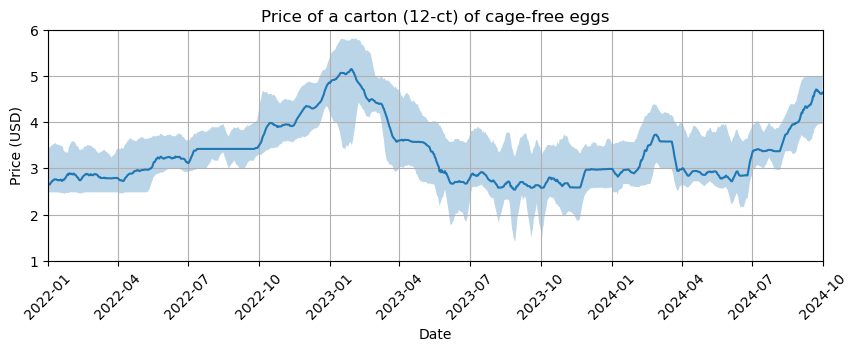

In [50]:
df = pd.read_parquet('egg_prices.parquet')\
        .sort_values(by='transaction_date')\
        .reset_index(drop=True)
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['median_price_7d'] = df['median_price'].rolling(7).mean()
df['lq_price_7d'] = df['lq_price'].rolling(7).mean()
df['uq_price_7d'] = df['uq_price'].rolling(7).mean()
df = df[df['transaction_date'].dt.year >= 2022].reindex()

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['transaction_date'],df['median_price_7d'])
ax.fill_between(df['transaction_date'],df['lq_price_7d'],df['uq_price_7d'],alpha=0.3)
ax.set_xlim(pd.to_datetime('2022-01-01'),pd.to_datetime('2024-10-01'))
ax.set_ylim(1,6)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.set_title('Price of a carton (12-ct) of cage-free eggs')
ax.tick_params(axis='x', rotation=45)
plt.savefig('egg_prices.png')
plt.show()